In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
from metagov import at2df 
from metagov.plotutils import plot_coded_column as _plot_coded_column
from metagov.utils import ast_eval, get_unique_col_values

kw_plot = {'scaleToMax': False}
def plot_coded_column(df, name, label=None):
    _plot_coded_column(df, name, label=label, **kw_plot)

## Import data and check what's generally in it

In [3]:
def load_data(overwrite=False):
    """Load Contract Objects and Contract Parameters "Keyword-coded records views from Govbase"
    (or, locally from file if it exists)"""
    
    datapath_objects = 'tmp/airtable_contract_objects_data.csv'
    datapath_params = 'tmp/airtable_contract_parameters_data.csv'
    
    if overwrite or not (os.path.isfile(datapath_objects) and os.path.isfile(datapath_params)):
        # Load from Airtable
        at = at2df.get_airtable()
        kwargs = {'view': 'Keyword-coded records'}
        df_objects = at2df.get_table_as_df(at, 'Contract Objects', kwargs=kwargs)
        df_params = at2df.get_table_as_df(at, 'Contract Parameters', kwargs=kwargs)
        
        # Drop unnecessary colums and load list columns
        df_objects.drop(columns=['notice', 'full_comment', 'param', 'return', 'dev', 'title',
                                 'coding_keyword_search', 'coding_topic_search',
                                 'coding_keyword_search_options', 'coding_topic_search_options',
                                 'url', 'repo_url', 'repo_update_datetime', 'repo_version'
                                ], 
                        inplace=True, errors='ignore')
        df_params.drop(columns=['full_comment', 'coding_keyword_search_options_from_object', 
                                'project_from_object', 'type_from_object', 'visibility_from_object',
                                'url'], 
                       inplace=True, errors='ignore')
        
        # Load list columns (and convert always-single-item list to string)
        for col in ['inheritance', 'modifiers', 'values']:
            df_objects[col] = df_objects[col].apply(ast_eval)
        df_params['object_id'] = df_params['object_id'].apply(lambda x: x[0] if isinstance(x, list) else x)
        
        # Save to local file
        df_objects.to_csv(datapath_objects)
        df_params.to_csv(datapath_params)

    else:
        # Load from local file
        df_objects = pd.read_csv(datapath_objects, index_col=0)
        df_params = pd.read_csv(datapath_params, index_col=0)
        
        # Load list columns
        for col in ['contract_parameters', 'hand_coding', 'inheritance', 'modifiers', 'values']:
            df_objects[col] = df_objects[col].apply(ast_eval)
        for col in ['hand_coding_from_object']:
            df_params[col] = df_params[col].apply(ast_eval)

    # Load child parameter names into df_objects for ease of analysis
    df_objects['contract_parameters_names'] = df_objects['contract_parameters'].apply(
        lambda values: [df_params.at[v, 'parameter_name'] for v in values] if isinstance(values, list) else np.nan
    )

    # Note that this assumes that the parent object of each parameter has been tagged with the same keyword;
    # This is enforced in the automated version, but could possibly have been broken in the hand-coding, so watch out for this
    df_params['project'] = df_params['object_id'].apply(lambda v: df_objects.at[v,'project'])

    return {'objects': df_objects, 'parameters': df_params}

In [4]:
data = load_data()
df_objects, df_params = data.values()

In [5]:
df_objects.head()

,contract,type,inheritance,visibility,project,description,object_name,contract_parameters,hand_coding,object_id,is_interface,modifiers,values,contract_parameters_names
id,,,,,,,,,,,,,,
recoLQ7q54IdNJEsJ,CommonStorage,ContractDefinition,[DSAuth],NaN,Colony - Colony Network,ignore-file-swc-131\nignore-file-swc-108,CommonStorage,"[recEcLkjBIBM2Y5YT, recVsW2krM7UuagVx, recyFXB...",[membership],CommonStorage: CommonStorage (JoinColony/colo...,0,NaN,NaN,"[UINT256_MAX, AUTHORITY_SLOT, OWNER_SLOT, RESO..."
rec918lQeIeyoyxja,ContractRecovery,FunctionDefinition,NaN,public,Colony - Colony Network,NaN,approveExitRecovery,NaN,[membership],ContractRecovery: approveExitRecovery (JoinCo...,0,"[recovery, auth]",[],NaN
recXwa9USIDVfYP12,ContractRecovery,FunctionDefinition,NaN,public,Colony - Colony Network,Can only be called by the root role,setRecoveryRole,[recNXPpVtY9FZ1bzS],[membership],ContractRecovery: setRecoveryRole (JoinColony...,0,"[stoppable, auth]",[],[_user]
recmtcdwC95Fbkl3v,ContractRecovery,FunctionDefinition,NaN,public,Colony - Colony Network,Can only be called by the root role,removeRecoveryRole,[recVPDgSaIhAd9GzA],[membership],ContractRecovery: removeRecoveryRole (JoinCol...,0,"[stoppable, auth]",[],[_user]
recGhCmYVvyVLn3pL,ContractRecovery,FunctionDefinition,NaN,public,Colony - Colony Network,NaN,numRecoveryRoles,NaN,[membership],ContractRecovery: numRecoveryRoles (JoinColon...,0,[],[],NaN


In [6]:
KEYWORDS = get_unique_col_values(df_objects, 'hand_coding')

dispute_resolution
election
membership
proposal
reputation
voting


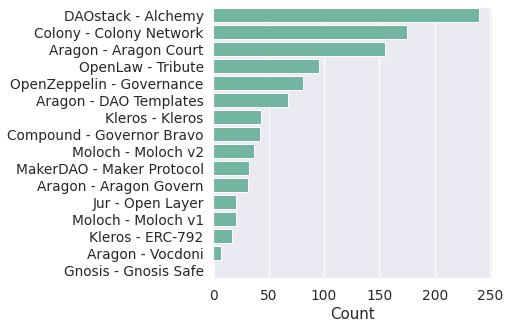

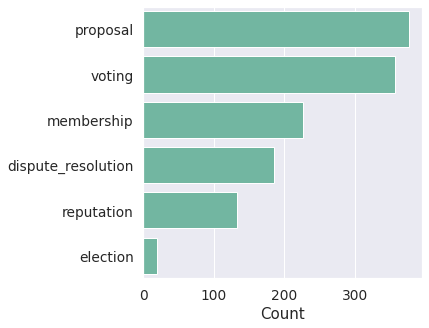

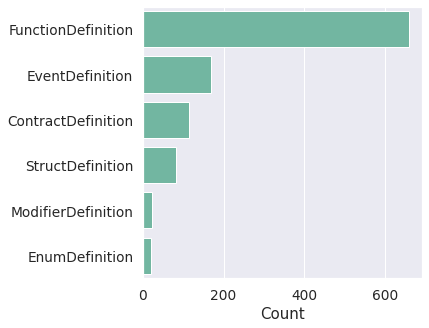

In [7]:
plot_coded_column(df_objects, 'project')
plot_coded_column(df_objects, 'hand_coding')
plot_coded_column(df_objects, 'type')

In [8]:
print(f"Including data from {len(df_objects['project'].unique())} projects")
print(f"Found {len(df_objects.index)} keyword-coded contract objects and {len(df_params.index)} parameters")
print(f"Keywords include: {', '.join(KEYWORDS)}")

Including data from 16 projects
Found 1067 keyword-coded contract objects and 3819 parameters
Keywords include: dispute_resolution, election, membership, proposal, reputation, voting


In [9]:
df_params.head()

,parameter_name,contract,object_name,visibility,description,type_category,type,object_id,hand_coding_from_object,project
id,,,,,,,,,,
recJoPGJe4per156W,termRandomness,JurorsRegistry,DraftParams,NaN,Randomness seed to be used for the draft,bytes,bytes32,recKevkh70FBHGVVM,"[dispute_resolution, election]",Aragon - Aragon Court
recuddMFdFT33eRZU,disputeId,JurorsRegistry,DraftParams,NaN,ID of the dispute being drafted,uint,uint256,recKevkh70FBHGVVM,"[dispute_resolution, election]",Aragon - Aragon Court
recKtUAJOBvvgHwLg,termId,JurorsRegistry,DraftParams,NaN,Term ID of the dispute's draft term,uint,uint64,recKevkh70FBHGVVM,"[dispute_resolution, election]",Aragon - Aragon Court
rec5IwiDrths5mfhn,selectedJurors,JurorsRegistry,DraftParams,NaN,Number of jurors already selected for the draft,uint,uint256,recKevkh70FBHGVVM,"[dispute_resolution, election]",Aragon - Aragon Court
recsMoLogv5hFwhBZ,batchRequestedJurors,JurorsRegistry,DraftParams,NaN,Number of jurors to be selected in the given b...,uint,uint256,recKevkh70FBHGVVM,"[dispute_resolution, election]",Aragon - Aragon Court


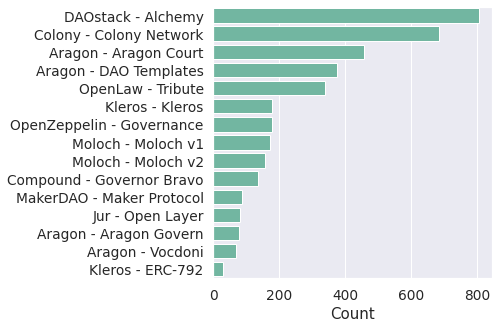

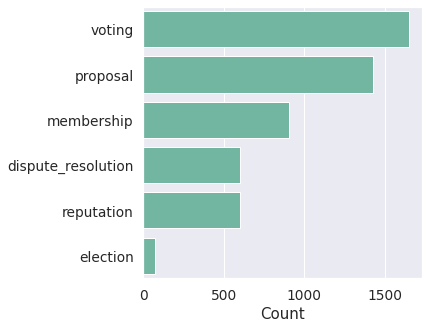

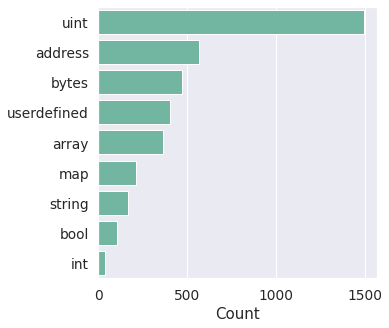

In [10]:
plot_coded_column(df_params, 'project')
plot_coded_column(df_params, 'hand_coding_from_object')
plot_coded_column(df_params, 'type_category')

## By object type

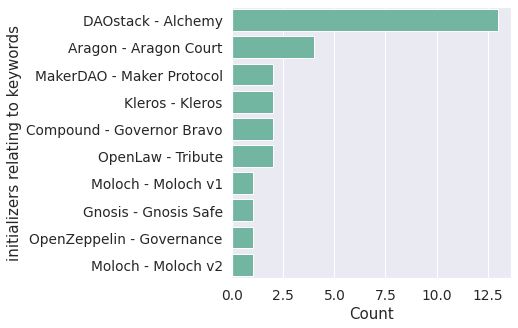

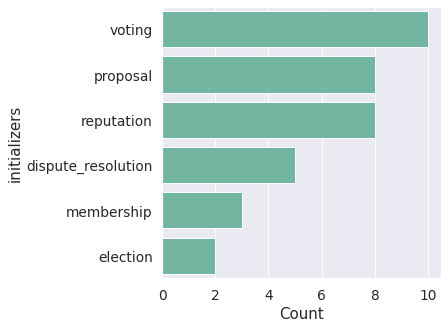

In [11]:
df_init = df_objects[df_objects['object_name'].isin(['constructor', 'initialize'])]
plot_coded_column(df_init, 'project', label='initializers relating to keywords')
plot_coded_column(df_init, 'hand_coding', label='initializers')

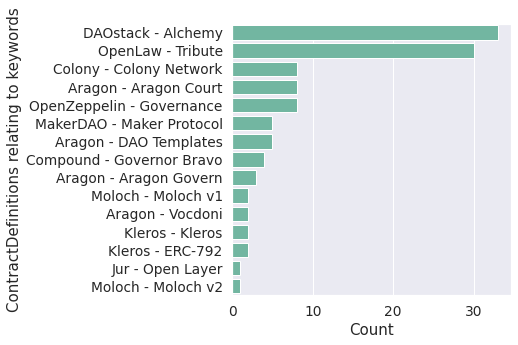

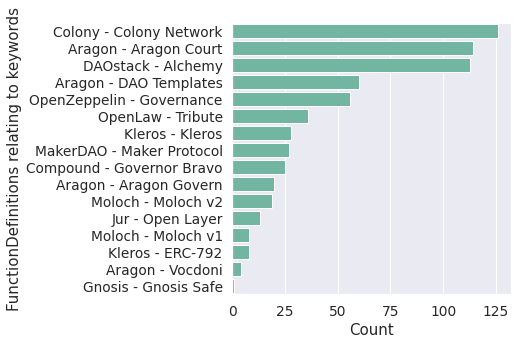

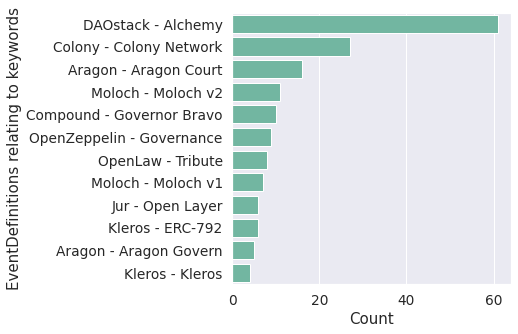

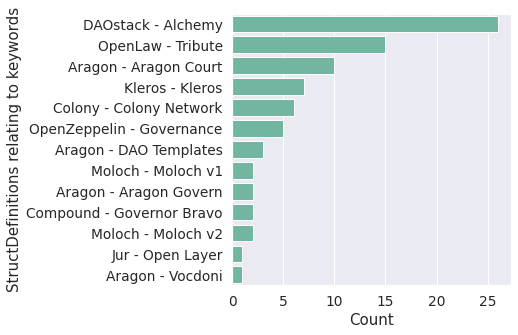

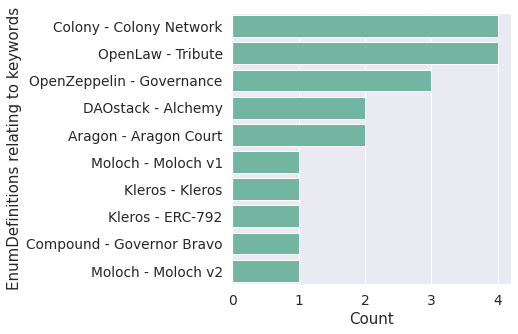

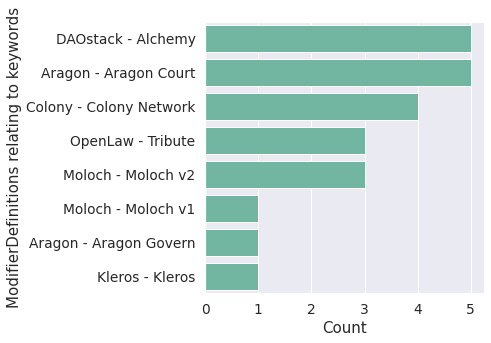

In [12]:
dfs_by_type = {
    t: df_objects[df_objects['type'] == t] for t in df_objects.type.unique()
}

for t, df in dfs_by_type.items():
    plot_coded_column(df, 'project', label=f'{t}s relating to keywords')


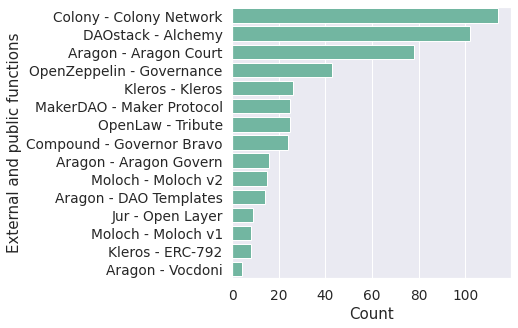

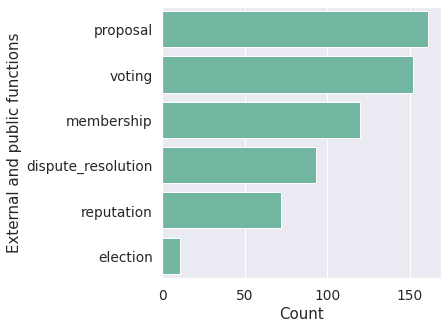

In [13]:
df_functions = dfs_by_type['FunctionDefinition']
df_ext_funcs = df_functions[df_functions['visibility'].isin(['external', 'public'])]
plot_coded_column(df_ext_funcs, 'project', label='External and public functions')
plot_coded_column(df_ext_funcs, 'hand_coding', label='External and public functions')

In [14]:
# Configurable parameters at initialization of governance smart contracts
df_init.sort_values(by='project', inplace=True)
for i, row in df_init.iterrows():
    params = row['contract_parameters']
    print(f"{row['project']}, {row['contract']}:")
    if isinstance(params, list):
        parameterNames = [df_params.loc[ref, 'parameter_name'] for ref in params]
        print("\t" + "\n\t".join(parameterNames) + "\n")
    else:
        print("\tNone\n")

Aragon - Aragon Court, DisputeManager:
	_controller
	_maxJurorsPerDraftBatch
	_skippedDisputes

Aragon - Aragon Court, CourtConfig:
	_feeToken
	_fees
	_roundStateDurations
	_pcts
	_roundParams
	_appealCollateralParams
	_minActiveBalance

Aragon - Aragon Court, Controller:
	_termParams
	_governors
	_feeToken
	_fees
	_roundStateDurations
	_pcts
	_roundParams
	_appealCollateralParams
	_minActiveBalance

Aragon - Aragon Court, AragonCourt:
	_termParams
	_governors
	_feeToken
	_fees
	_roundStateDurations
	_pcts
	_roundParams
	_appealCollateralParams
	_minActiveBalance

Compound - Governor Bravo, GovernorBravoDelegator:
	timelock_
	comp_
	admin_
	implementation_
	votingPeriod_
	votingDelay_
	proposalThreshold_

Compound - Governor Bravo, GovernorBravoDelegate:
	timelock_
	comp_
	votingPeriod_
	votingDelay_
	proposalThreshold_

DAOstack - Alchemy, ReputationAdmin:
	_avatar
	_activationStartTime
	_activationEndTime
	_maxRepReward

DAOstack - Alchemy, GenesisProtocolLogic:
	_stakingToken

DAOst

/tmp/ipykernel_153247/2760519353.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_init.sort_values(by='project', inplace=True)
